<a href="https://colab.research.google.com/github/nicoleolivetto/CNN/blob/main/AC_Denoising_dirty_documents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import numpy as np
from keras.layers import Input, Dense,Conv2D,MaxPooling2D,UpSampling2D,BatchNormalization
from keras.models import Model,Sequential
import matplotlib.pyplot as plt
import cv2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
!unzip train.zip
!unzip test.zip
!unzip train_cleaned.zip
!unzip sampleSubmission.csv.zip

Archive:  train.zip
   creating: train/
  inflating: train/101.png           
  inflating: train/102.png           
  inflating: train/104.png           
  inflating: train/105.png           
 extracting: train/107.png           
 extracting: train/108.png           
 extracting: train/11.png            
  inflating: train/110.png           
 extracting: train/111.png           
  inflating: train/113.png           
  inflating: train/114.png           
 extracting: train/116.png           
  inflating: train/117.png           
 extracting: train/119.png           
 extracting: train/12.png            
 extracting: train/120.png           
  inflating: train/122.png           
 extracting: train/123.png           
  inflating: train/125.png           
  inflating: train/126.png           
  inflating: train/128.png           
  inflating: train/129.png           
  inflating: train/131.png           
 extracting: train/132.png           
 extracting: train/134.png           
 extractin

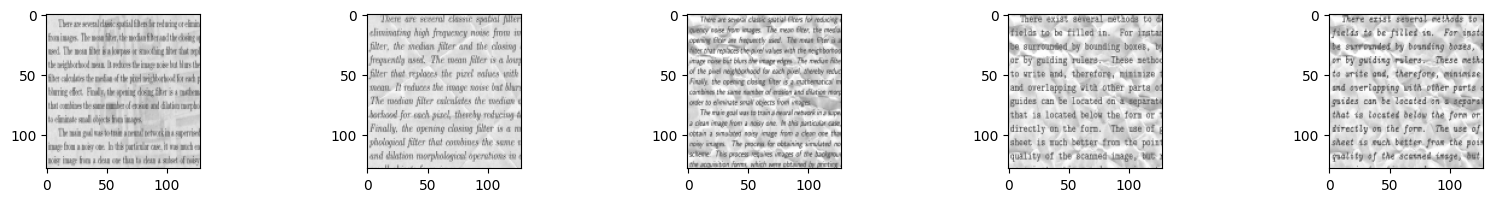

In [3]:
plt.figure(figsize=(20, 2))
for root, dirs, files in os.walk('train'):
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        img = cv2.imread(os.path.join(root,files[i]))
        resized = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)
        plt.imshow(resized)
plt.show()

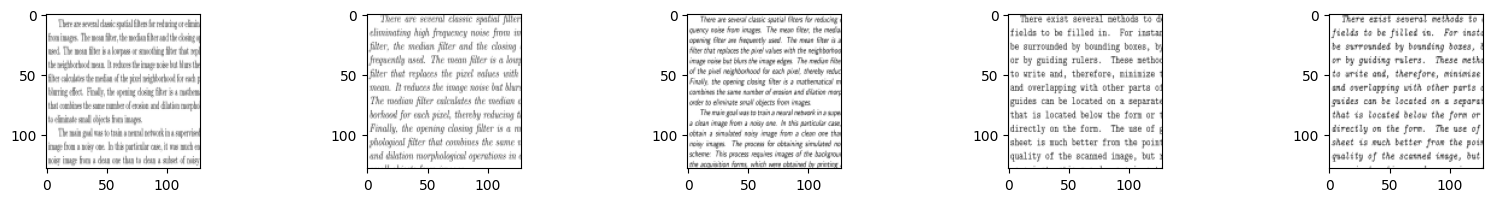

In [4]:
plt.figure(figsize=(20, 2))
for root, dirs, files in os.walk('train_cleaned'):
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        img = cv2.imread(os.path.join(root,files[i]))
        resized = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)
        plt.imshow(resized)
plt.show()

In [5]:
# Load train and train_cleaned data
train_data = []
train_data_cleaned = []
train_path = 'train'
train_cleaned_path = 'train_cleaned'



for filename in os.listdir(train_path):
    train_img = cv2.imread(os.path.join(train_path,filename))
    train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2GRAY)
    train_img = cv2.resize(train_img,(540, 258),interpolation = cv2.INTER_AREA)
    train_img = train_img.astype('float32')
    train_img = train_img/255.0
    train_data.append(train_img)
    train_cleaned_img = cv2.imread(os.path.join(train_cleaned_path,filename))
    train_cleaned_img = cv2.cvtColor(train_cleaned_img, cv2.COLOR_BGR2GRAY)
    train_cleaned_img = cv2.resize(train_cleaned_img,(540, 258),interpolation = cv2.INTER_AREA)
    train_cleaned_img = train_cleaned_img.astype('float32')
    train_cleaned_img = train_cleaned_img/255.0
    train_data_cleaned.append(train_cleaned_img)

In [6]:
# Let's stack the images
train_data = np.stack(train_data)
train_data_cleaned = np.stack(train_data_cleaned)

# Reshaping the data for model
train_data = train_data.reshape(train_data.shape[0],train_data.shape[1],train_data.shape[2],1)
train_data_cleaned = train_data_cleaned.reshape(train_data_cleaned.shape[0],train_data_cleaned.shape[1],train_data_cleaned.shape[2],1)



x_train,x_val,y_train,y_val = train_test_split(train_data,train_data_cleaned,test_size=0.2)

In [7]:
# Define the model
input_img = Input(shape=(258,540,1))
encoder = Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='elu')(input_img)
encoder = MaxPooling2D((2,2))(encoder)
decoder = Conv2D(64,kernel_size=(3,3),padding='same',activation='elu')(encoder)
decoder = UpSampling2D((2,2))(decoder)
decoder = Conv2D(1,kernel_size=(3,3),padding='same',activation='sigmoid')(decoder)
autoencoder = Model(input_img,decoder)
autoencoder.compile(loss='binary_crossentropy',optimizer='adam',metrics=['mse'])

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 258, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 258, 540, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 129, 270, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 129, 270, 64)      36928     
                                                                 
 up_sampling2d (UpSampling2  (None, 258, 540, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 258, 540, 1)       577   

In [8]:
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=1, mode='auto')

In [9]:
history = autoencoder.fit(x_train,y_train,epochs=100,batch_size=20,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 18s 854ms/step - loss: 0.4445 - mse: 0.1068 - val_loss: 0.3448 - val_mse: 0.0661
Epoch 2/100
6/6 [==============================] - 1s 205ms/step - loss: 0.3442 - mse: 0.0646 - val_loss: 0.3355 - val_mse: 0.0648
Epoch 3/100
6/6 [==============================] - 1s 202ms/step - loss: 0.3060 - mse: 0.0568 - val_loss: 0.3093 - val_mse: 0.0542
Epoch 4/100
6/6 [==============================] - 1s 202ms/step - loss: 0.2957 - mse: 0.0506 - val_loss: 0.2876 - val_mse: 0.0502
Epoch 5/100
6/6 [==============================] - 1s 203ms/step - loss: 0.2729 - mse: 0.0489 - val_loss: 0.2752 - val_mse: 0.0512
Epoch 6/100
6/6 [==============================] - 1s 205ms/step - loss: 0.2570 - mse: 0.0458 - val_loss: 0.2508 - val_mse: 0.0406
Epoch 7/100
6/6 [==============================] - 1s 197ms/step - loss: 0.2364 - mse: 0.0357 - val_loss: 0.2309 - val_mse: 0.0333
Epoch 8/100
6/6 [==============================] - 1s 205ms/step - loss: 0.2160 - 

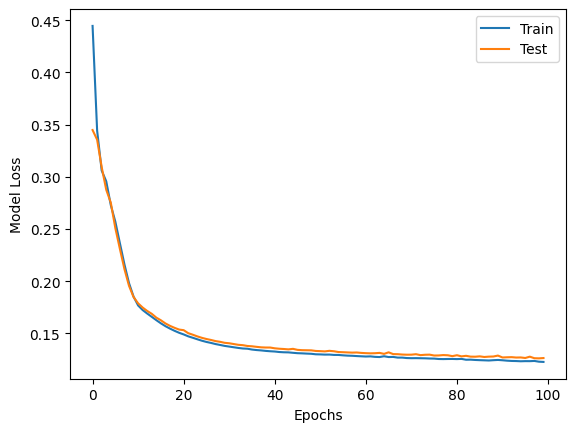

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Model Loss')
plt.legend(['Train', 'Test'])
plt.show()